In [1]:
! pip install xgboost

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from scipy import stats
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import median_absolute_error
from datetime import date
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb


In [ ]:
# Run this cell to import or install the Data Wrangler widget to show automatic visualization and generate code to fix data quality issues

try:
    import sagemaker_datawrangler
except ImportError:
    !pip install --upgrade sagemaker-datawrangler
    import sagemaker_datawrangler

# Display Pandas DataFrame to view the widget: df, display(df), df.sample()... 

In [2]:
df=pd.read_csv('Fractionator.csv')

In [3]:
df['Time']=pd.to_datetime(df['Time'])

In [4]:
df=df[(np.abs(stats.zscore(df["AI_2020_OVERHEAD_C5'S_MOL"])) < 3)]

In [5]:
df.rename(columns = {"AI_2020_OVERHEAD_C5'S_MOL":"AI_top","AI_2021_MIDDLE_C7'S_MOL":"AI_middle","AI_2022_BOTTOM_C3'S_MOL":"AI_bottom",
                          'FIC_2100_PV_FEED_FURNACE_FUEL_SCFH':'Furnace' ,'FIC_2004_PV_TOP_REFLUX_MBBL/D':'Reflux_top',
                    'FI-2005_PV_FEED_FLOW_MBBL/D':'Feed'
 }, inplace = True)

In [6]:
df_uni=df[['AI_top','Furnace','Feed','Reflux_top',]]

In [7]:
df_Xgb=df_uni[['AI_top']]

In [8]:
df_Xgb.head()

,AI_top
0,2.00000
1,2.00360
2,2.00870
3,2.00385
4,1.99852


In [9]:
def df_to_X_y(df, window_size=10):
  df_np = df_Xgb.to_numpy()
  X = []
  y = []
  for i in range(len(df_np)-window_size):
    row = [r for r in df_np[i:i+window_size]]
    X.append(row)
    label = df_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [10]:
X,y= df_to_X_y(df_Xgb,window_size=10)
X.shape, y.shape

((5719, 10, 1), (5719,))

In [11]:
y=y.reshape([5719])
y.shape
X=X.reshape(5719, 10)
X.shape

(5719, 10)

In [12]:
split_index = int(len(X) * 0.8)

split_index

4575

In [13]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4575, 10), (1144, 10), (4575,), (1144,))

In [14]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[12:32:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.61464	validation_1-rmse:1.87974
[100]	validation_0-rmse:0.59392	validation_1-rmse:0.68930
[200]	validation_0-rmse:0.21889	validation_1-rmse:0.25219
[300]	validation_0-rmse:0.08119	validation_1-rmse:0.09188
[400]	validation_0-rmse:0.03118	validation_1-rmse:0.03372
[500]	validation_0-rmse:0.01424	validation_1-rmse:0.01397
[600]	validation_0-rmse:0.00954	validation_1-rmse:0.00910
[700]	validation_0-rmse:0.00837	validation_1-rmse:0.00839
[800]	validation_0-rmse:0.00792	validation_1-rmse:0.00830
[900]	validation_0-rmse:0.00765	validation_1-rmse:0.00828
[999]	validation_0-rmse:0.00746	validation_1-rmse:0.00825


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

In [15]:
trained_predicted=reg.predict(X_train)


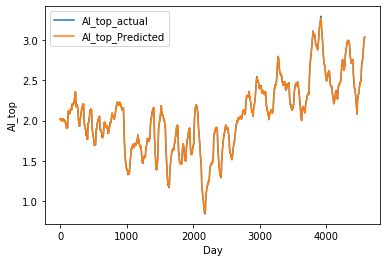

In [16]:
plt.plot(y_train, label='AI_top_actual')
plt.plot(trained_predicted, label='AI_top_Predicted')
plt.xlabel('Day')
plt.ylabel('AI_top')
plt.legend()
plt.savefig("Xgboost time series train")
plt.show()

In [18]:
tested_predicted=reg.predict(X_test)


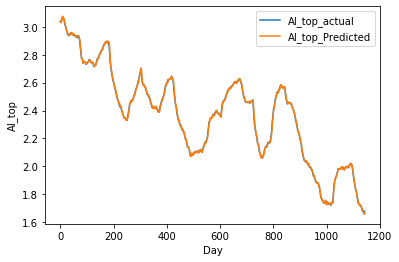

In [19]:
plt.plot(y_test, label='AI_top_actual')
plt.plot(tested_predicted, label='AI_top_Predicted')
plt.xlabel('Day')
plt.ylabel('AI_top')
plt.legend()
plt.savefig("Xgboost time series valid")
plt.show()

In [20]:
df.corr()

,AI_top,AI_middle,AI_bottom,Furnace,FIC-2101_PV_TOP_PRODUCT_MBBL/D,FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D,Feed,FIC-2001_SP_TOP_REFLUX_SETPOINT_MBBL/D,FIC-2001_OP_TOP_REFLUX_OUTPUT_%,FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D,FIC-2002_SP_MIDDLE_PRODUCT_DRAW_SETPOINT_MBBL/D,FIC_2002_OP_MIDDLE_PRODUCT_DRAW_OUTPUT_%,FIC_2002_PVMIDDLE_PRODUCT_DRAW_MBBL/D,FIC_2004_SP_MIDDLE_REFLUX _SETPOINT_MBBL/D,FIC_2004_OP_MIDDLE_REFLUX_OUTPUT_%,Reflux_top,QI_2106_PV_MIDDLE_REFLUX_DUTY_BTU/H,TIC_2003_SP_FEED_TEMPERATURE_SETPOINT_DEGF
AI_top,1.000000,0.538482,-0.553021,0.407673,0.758709,-0.240672,0.488035,-0.455654,-0.443725,-0.447318,-0.154190,-0.120080,-0.153657,-0.464095,-0.373196,-0.466017,-0.539018,0.017222
AI_middle,0.538482,1.000000,-0.457908,0.171360,0.305365,-0.341537,0.197078,-0.006435,0.000307,-0.007227,0.129516,0.130855,0.125761,-0.555510,-0.425965,-0.558240,-0.455036,-0.084087
AI_bottom,-0.553021,-0.457908,1.000000,-0.687598,-0.700519,0.569137,-0.293440,0.063971,0.056297,0.067186,0.001222,-0.024260,0.003056,0.032907,-0.060178,0.035724,0.182601,-0.663618
Furnace,0.407673,0.171360,-0.687598,1.000000,0.785949,-0.020650,0.701633,0.026288,0.036836,0.024442,0.020266,0.041381,0.018173,0.447868,0.502408,0.444731,0.217991,0.705070
FIC-2101_PV_TOP_PRODUCT_MBBL/D,0.758709,0.305365,-0.700519,0.785949,1.000000,-0.226228,0.586865,-0.419776,-0.402920,-0.412695,-0.034356,-0.001350,-0.037769,0.034506,0.099093,0.031764,-0.211327,0.450846
FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D,-0.240672,-0.341537,0.569137,-0.020650,-0.226228,1.000000,0.371252,0.060521,0.052079,0.062734,-0.302132,-0.297423,-0.298491,0.308827,0.249892,0.310565,0.338084,-0.404779
Feed,0.488035,0.197078,-0.293440,0.701633,0.586865,0.371252,1.000000,-0.021923,-0.018033,-0.018566,-0.024602,-0.013751,-0.025568,0.270945,0.292929,0.267855,0.156073,0.194366
FIC-2001_SP_TOP_REFLUX_SETPOINT_MBBL/D,-0.455654,-0.006435,0.063971,0.026288,-0.419776,0.060521,-0.021923,1.000000,0.981528,0.980009,0.266313,0.243396,0.265144,0.170825,0.135397,0.170146,0.284550,0.174440
FIC-2001_OP_TOP_REFLUX_OUTPUT_%,-0.443725,0.000307,0.056297,0.036836,-0.402920,0.052079,-0.018033,0.981528,1.000000,0.991546,0.268394,0.244264,0.266644,0.166962,0.135121,0.166105,0.277906,0.180826
FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D,-0.447318,-0.007227,0.067186,0.024442,-0.412695,0.062734,-0.018566,0.980009,0.991546,1.000000,0.262816,0.239624,0.261001,0.167011,0.131806,0.166080,0.279231,0.168893


In [5]:
#splitting columns into groups according to data influence on the system
manipulated_variables=["AI_2020_OVERHEAD_C5'S_MOL", "AI_2021_MIDDLE_C7'S_MOL",
       "AI_2022_BOTTOM_C3'S_MOL"]
controlled_variables=[
       'FIC-2001_SP_TOP_REFLUX_SETPOINT_MBBL/D',
       'FIC-2001_OP_TOP_REFLUX_OUTPUT_%',
       'FIC-2002_SP_MIDDLE_PRODUCT_DRAW_SETPOINT_MBBL/D',
       'FIC_2002_OP_MIDDLE_PRODUCT_DRAW_OUTPUT_%',
       'FIC_2004_SP_MIDDLE_REFLUX _SETPOINT_MBBL/D',
       'FIC_2004_OP_MIDDLE_REFLUX_OUTPUT_%', 
       'TIC_2003_SP_FEED_TEMPERATURE_SETPOINT_DEGF']
response_variables=['FIC_2100_PV_FEED_FURNACE_FUEL_SCFH',
       'FIC-2101_PV_TOP_PRODUCT_MBBL/D', 'FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D',
       'FI-2005_PV_FEED_FLOW_MBBL/D',
       'FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D',
       'FIC_2002_PVMIDDLE_PRODUCT_DRAW_MBBL/D',
       'FIC_2004_PV_TOP_REFLUX_MBBL/D',
       'QI_2106_PV_MIDDLE_REFLUX_DUTY_BTU/H',]

In [6]:
X=df[manipulated_variables]
y=df[response_variables]
y.shape

(5729, 8)

In [26]:
len(response_variables)

8

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5729 entries, 0 to 5819
Data columns (total 19 columns):
Time                                               5729 non-null datetime64[ns]
AI_top                                             5729 non-null float64
AI_middle                                          5729 non-null float64
AI_bottom                                          5729 non-null float64
Furnace                                            5729 non-null float64
FIC-2101_PV_TOP_PRODUCT_MBBL/D                     5729 non-null float64
FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D                  5729 non-null float64
Feed                                               5729 non-null float64
FIC-2001_SP_TOP_REFLUX_SETPOINT_MBBL/D             5729 non-null float64
FIC-2001_OP_TOP_REFLUX_OUTPUT_%                    5729 non-null float64
FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D             5729 non-null float64
FIC-2002_SP_MIDDLE_PRODUCT_DRAW_SETPOINT_MBBL/D    5729 non-null float64
FIC_2002_O

In [29]:
import seaborn as sns

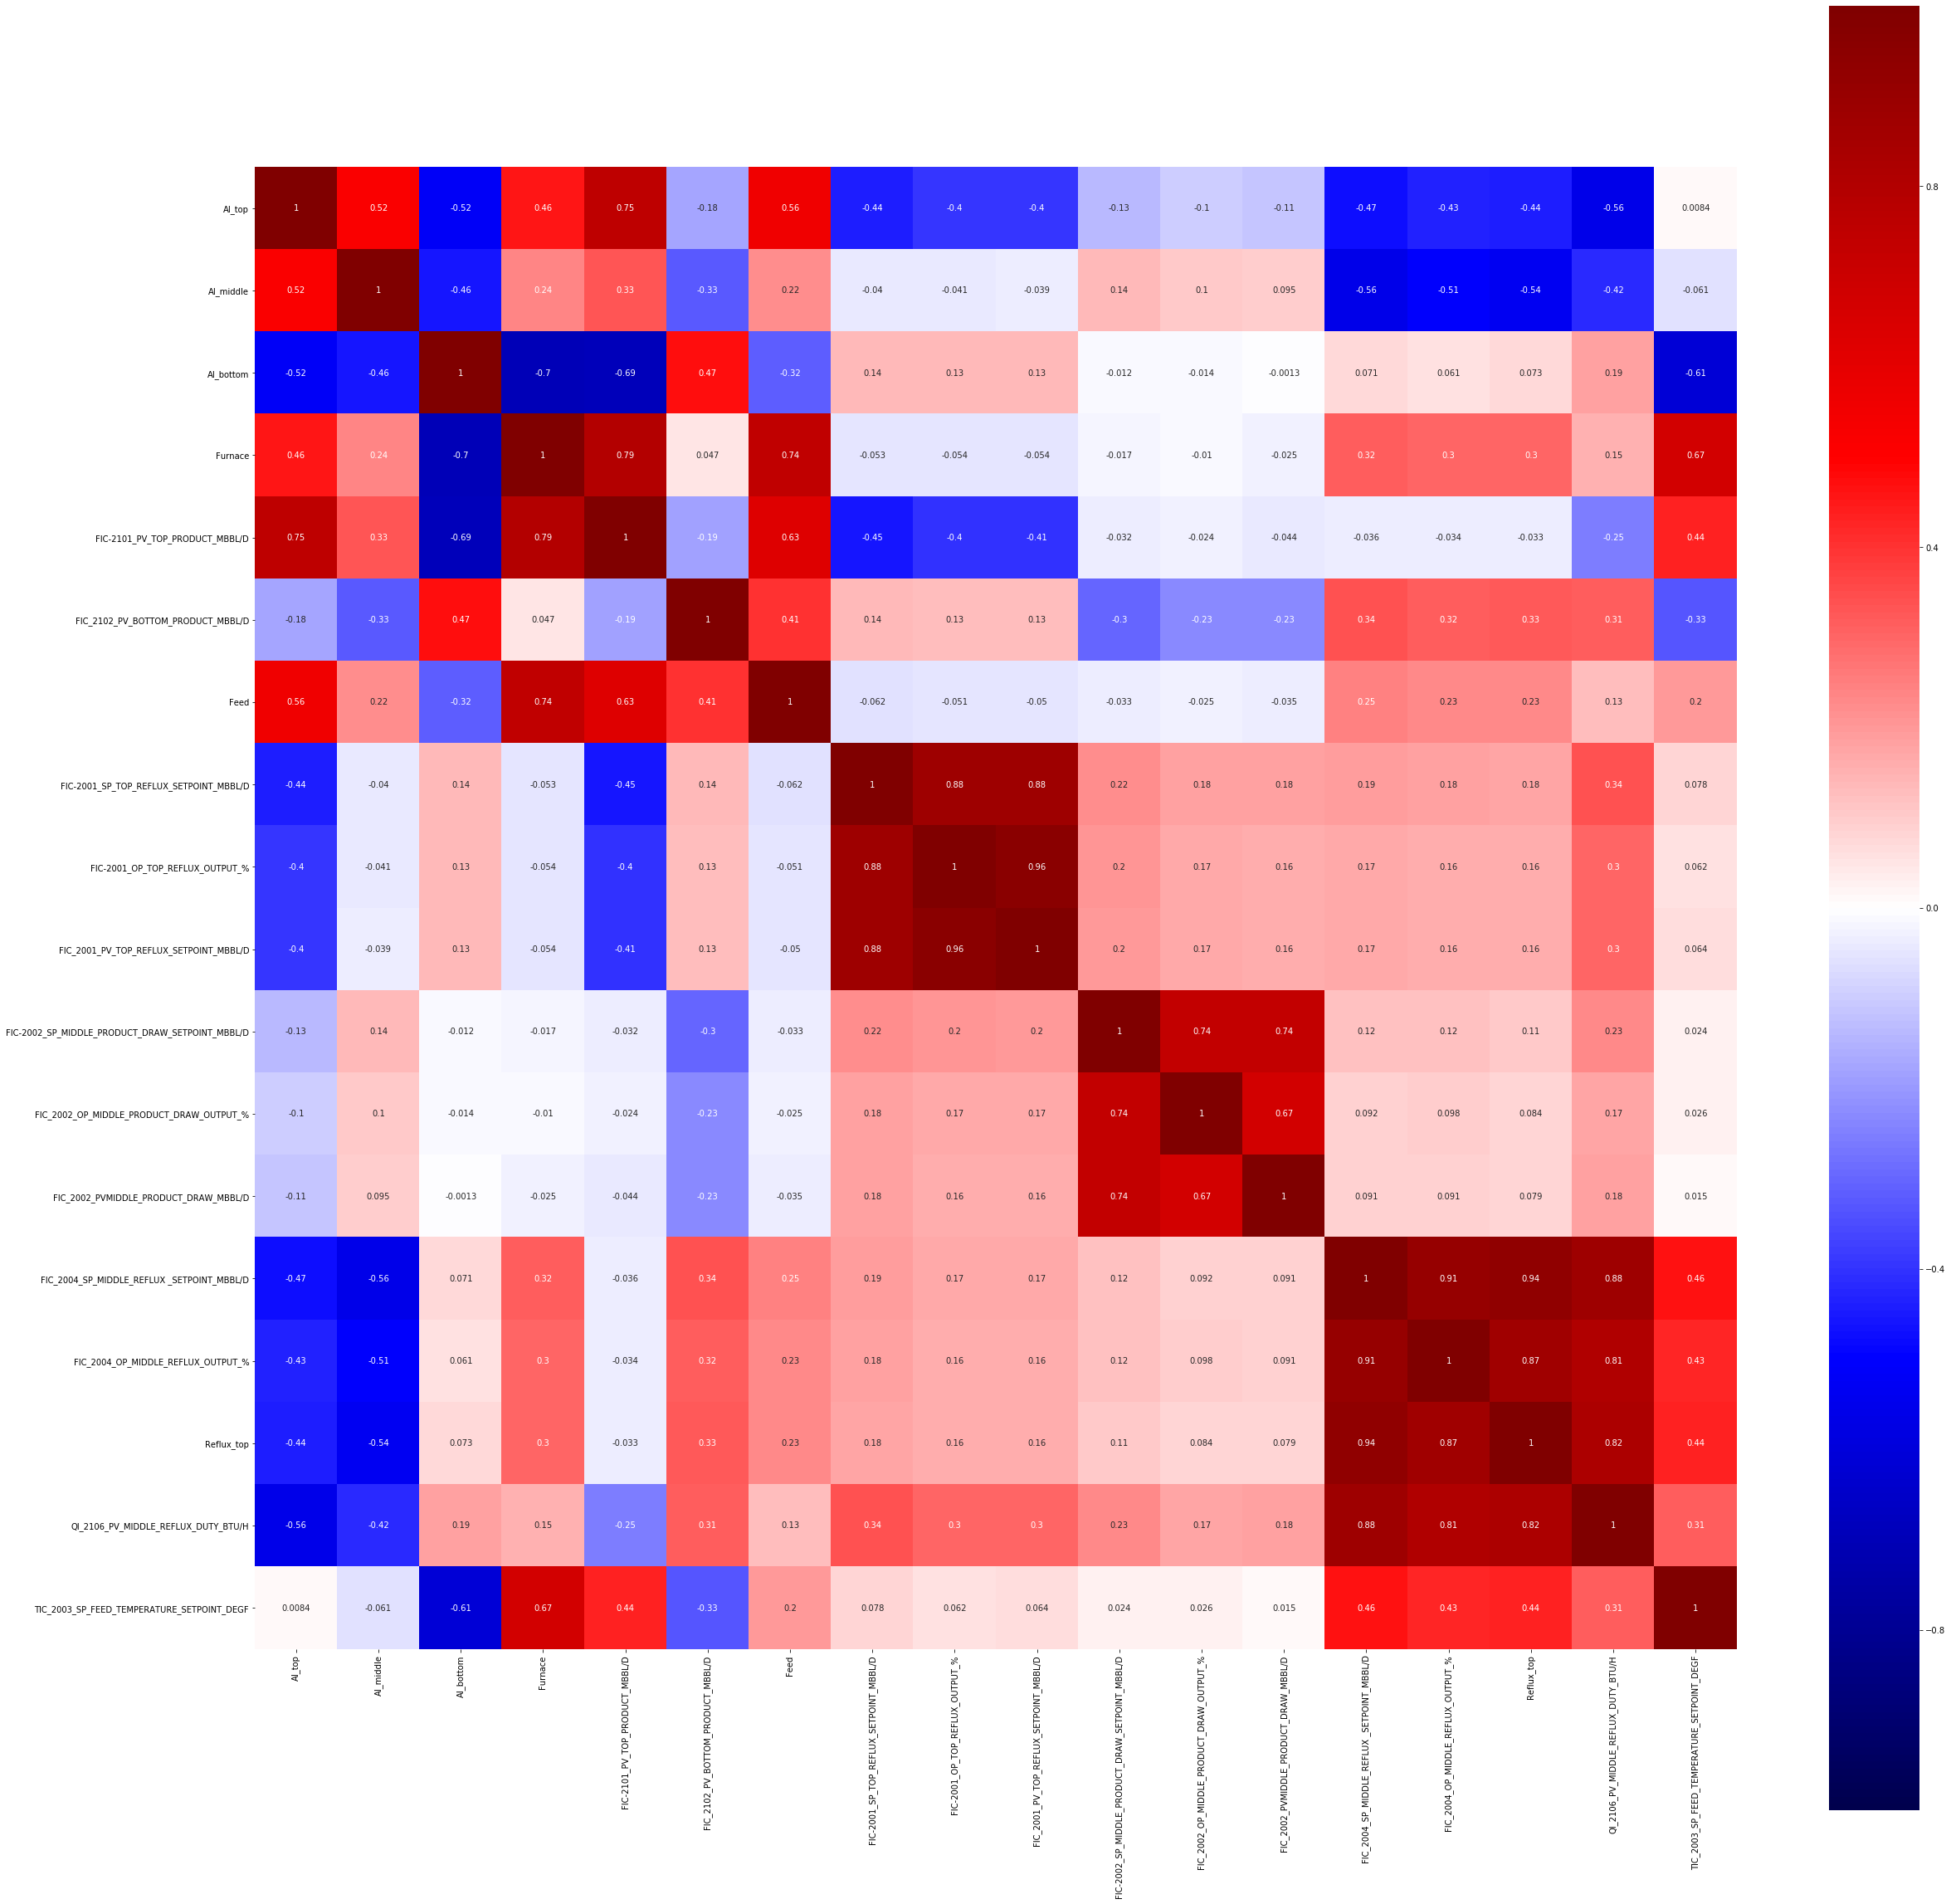

In [30]:
#find the correlation between features
plt.figure(figsize=(40,40))
fig1=sns.heatmap(df.corr(method='spearman'),vmin=-1,vmax=1,cmap= 'seismic',annot=True,square=True)
fig1.figure.savefig('heat map correlation.png')
plt.show()

In [7]:
df_response=df[response_variables]

In [38]:
df_AI1=df["AI_2020_OVERHEAD_C5'S_MOL"]
df_AI_top=pd.concat([df_AI1,df_response],axis=1)

In [39]:
df_AI2=df["AI_2021_MIDDLE_C7'S_MOL"]
df_AI_middle=pd.concat([df_AI2,df_response],axis=1)

In [40]:
df_AI3=df["AI_2022_BOTTOM_C3'S_MOL"]
df_AI_bottom=pd.concat([df_AI3,df_response],axis=1)

In [41]:
df_AI_top.head()

,AI_2020_OVERHEAD_C5'S_MOL,FIC_2100_PV_FEED_FURNACE_FUEL_SCFH,FIC-2101_PV_TOP_PRODUCT_MBBL/D,FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D,FI-2005_PV_FEED_FLOW_MBBL/D,FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D,FIC_2002_PVMIDDLE_PRODUCT_DRAW_MBBL/D,FIC_2004_PV_TOP_REFLUX_MBBL/D,QI_2106_PV_MIDDLE_REFLUX_DUTY_BTU/H
0,2.00000,8.50000,2.10000,1.70000,5.02153,2.64333,1.55033,8.06381,2.00000
1,2.00360,8.50735,2.09686,1.71730,4.98768,2.51377,1.43952,8.02407,1.99772
2,2.00870,8.50977,2.09280,1.72500,4.93990,2.39550,1.55065,7.92434,1.99552
3,2.00385,8.50838,2.08587,1.71878,4.93333,2.32773,1.50101,8.03058,1.99483
4,1.99852,8.50365,2.08028,1.71360,4.96880,2.50900,1.48210,8.06181,1.99465


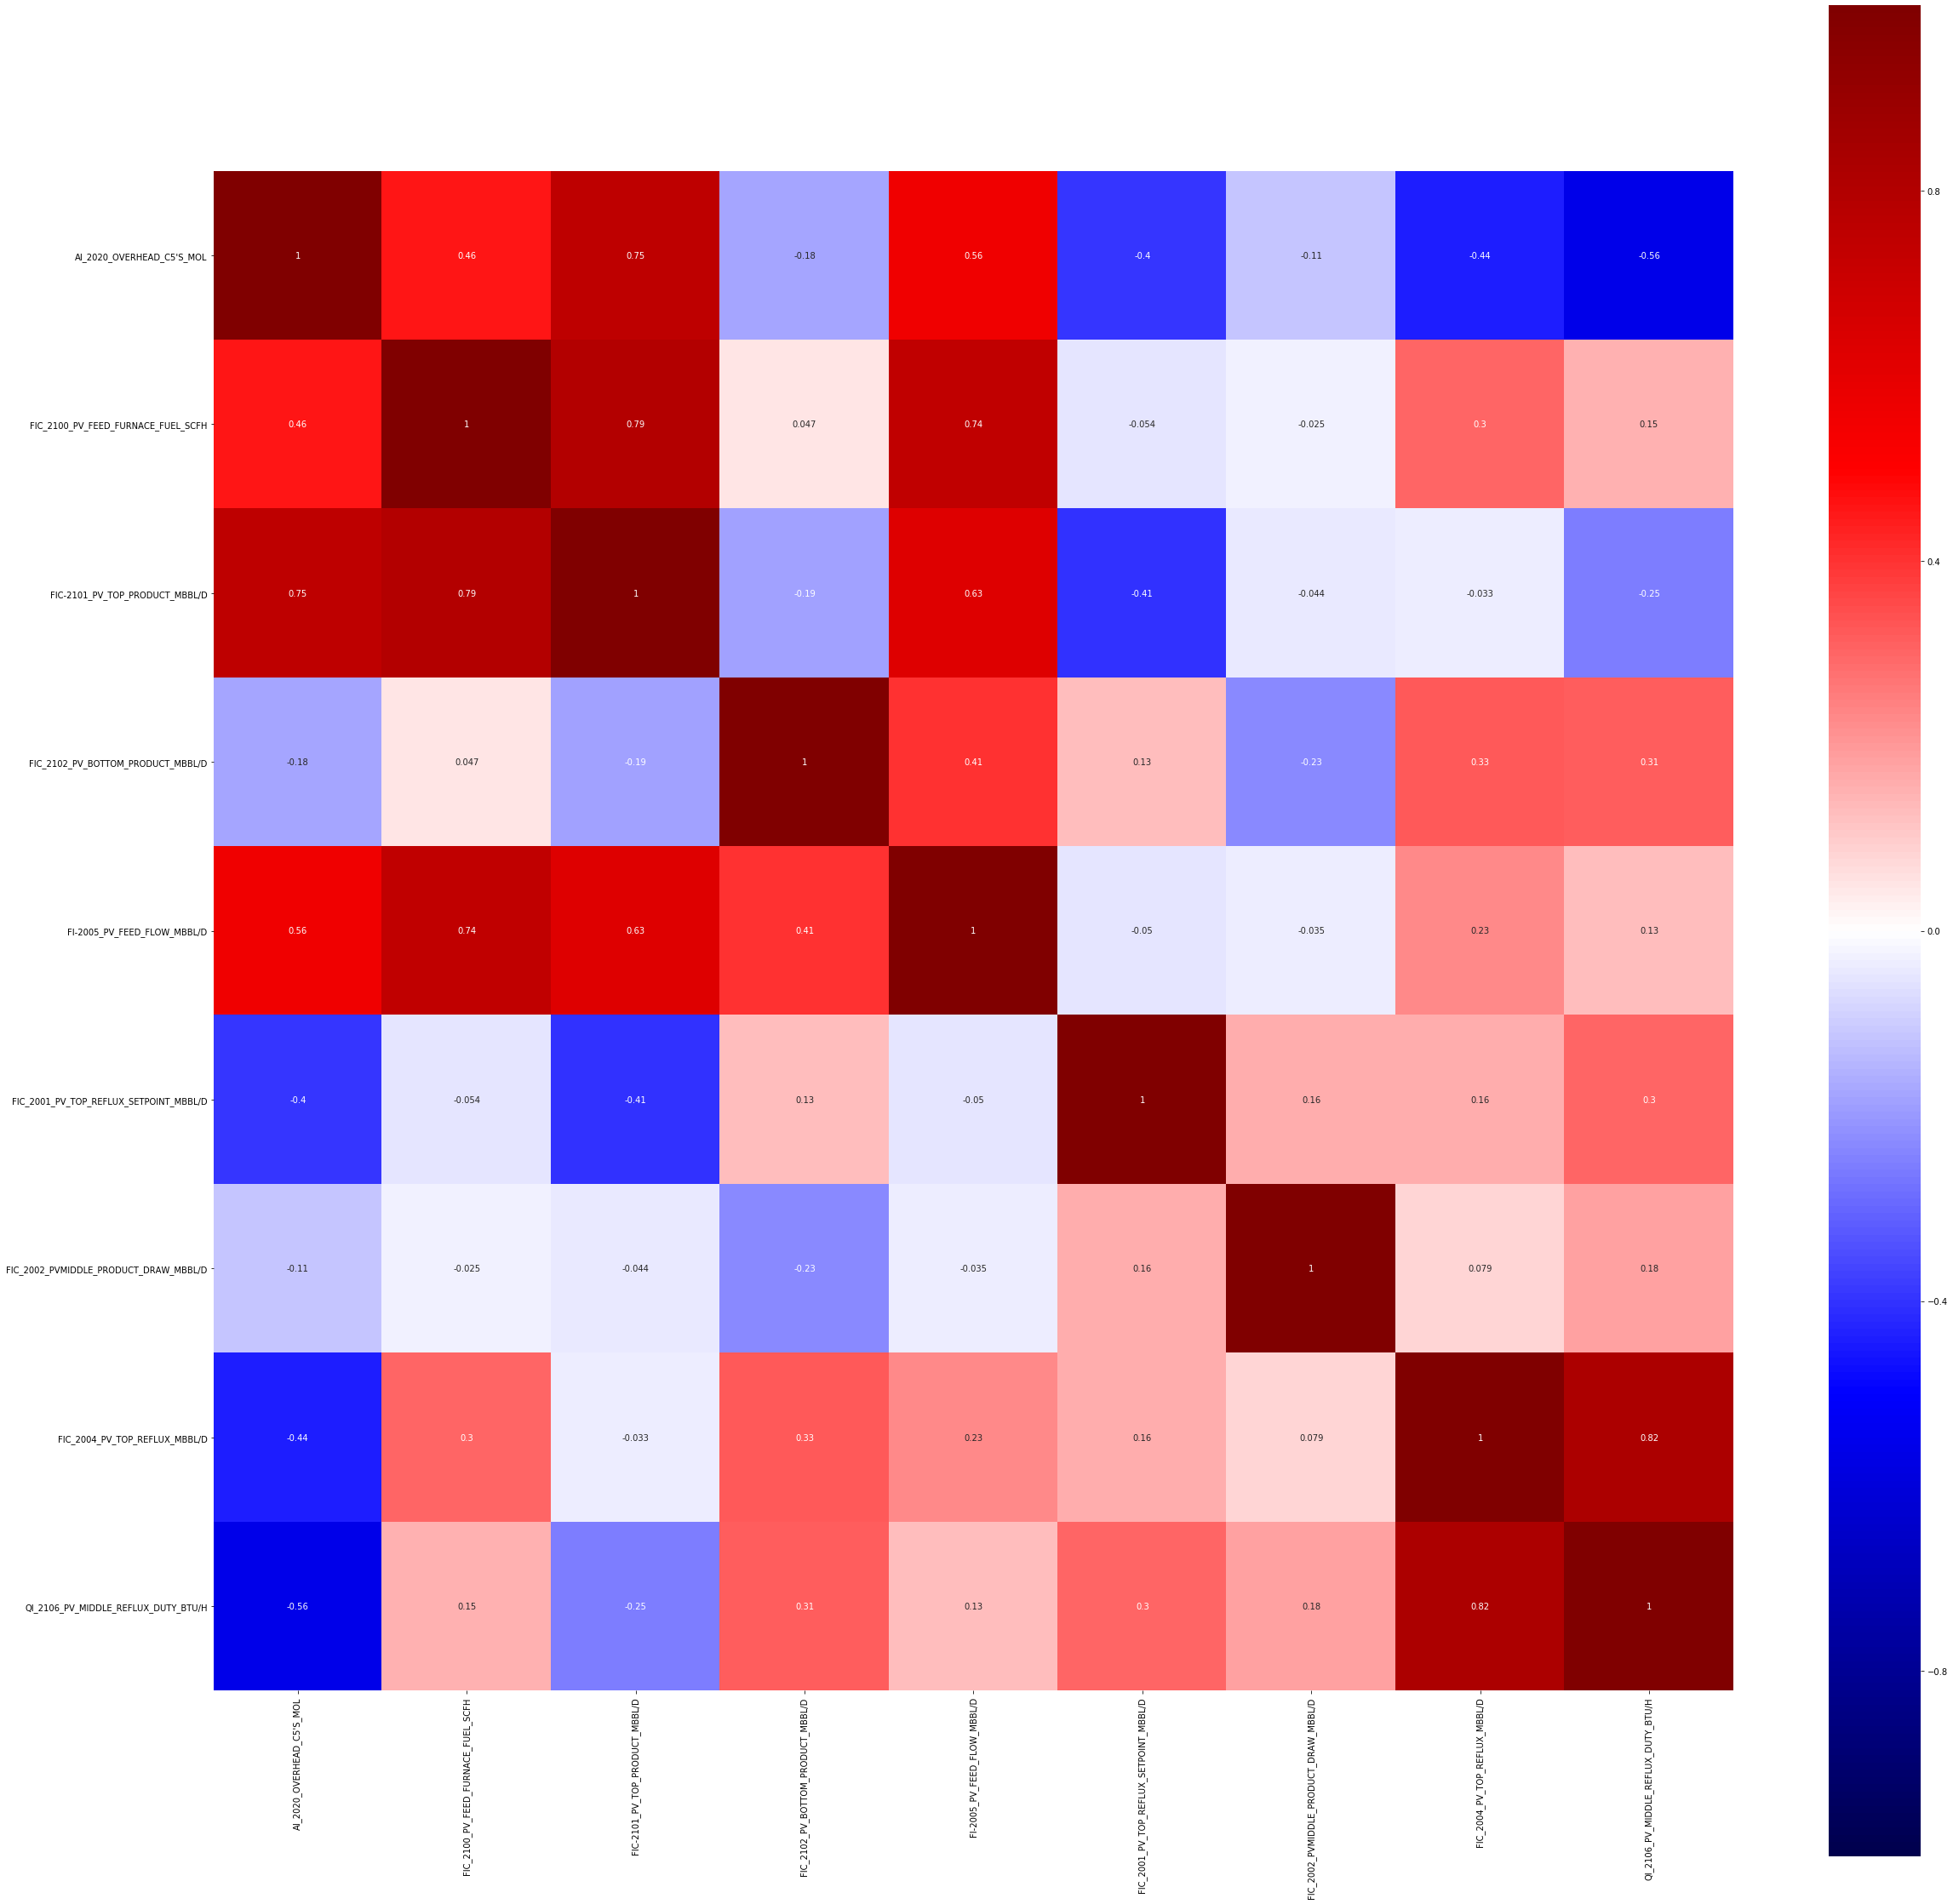

In [42]:
#find the correlation between features
plt.figure(figsize=(40,40))
fig2=sns.heatmap(df_AI_top.corr(method='spearman'),vmin=-1,vmax=1,cmap= 'seismic',annot=True,square=True)
fig2.figure.savefig('heat map correlation AI_top.png')
plt.show()

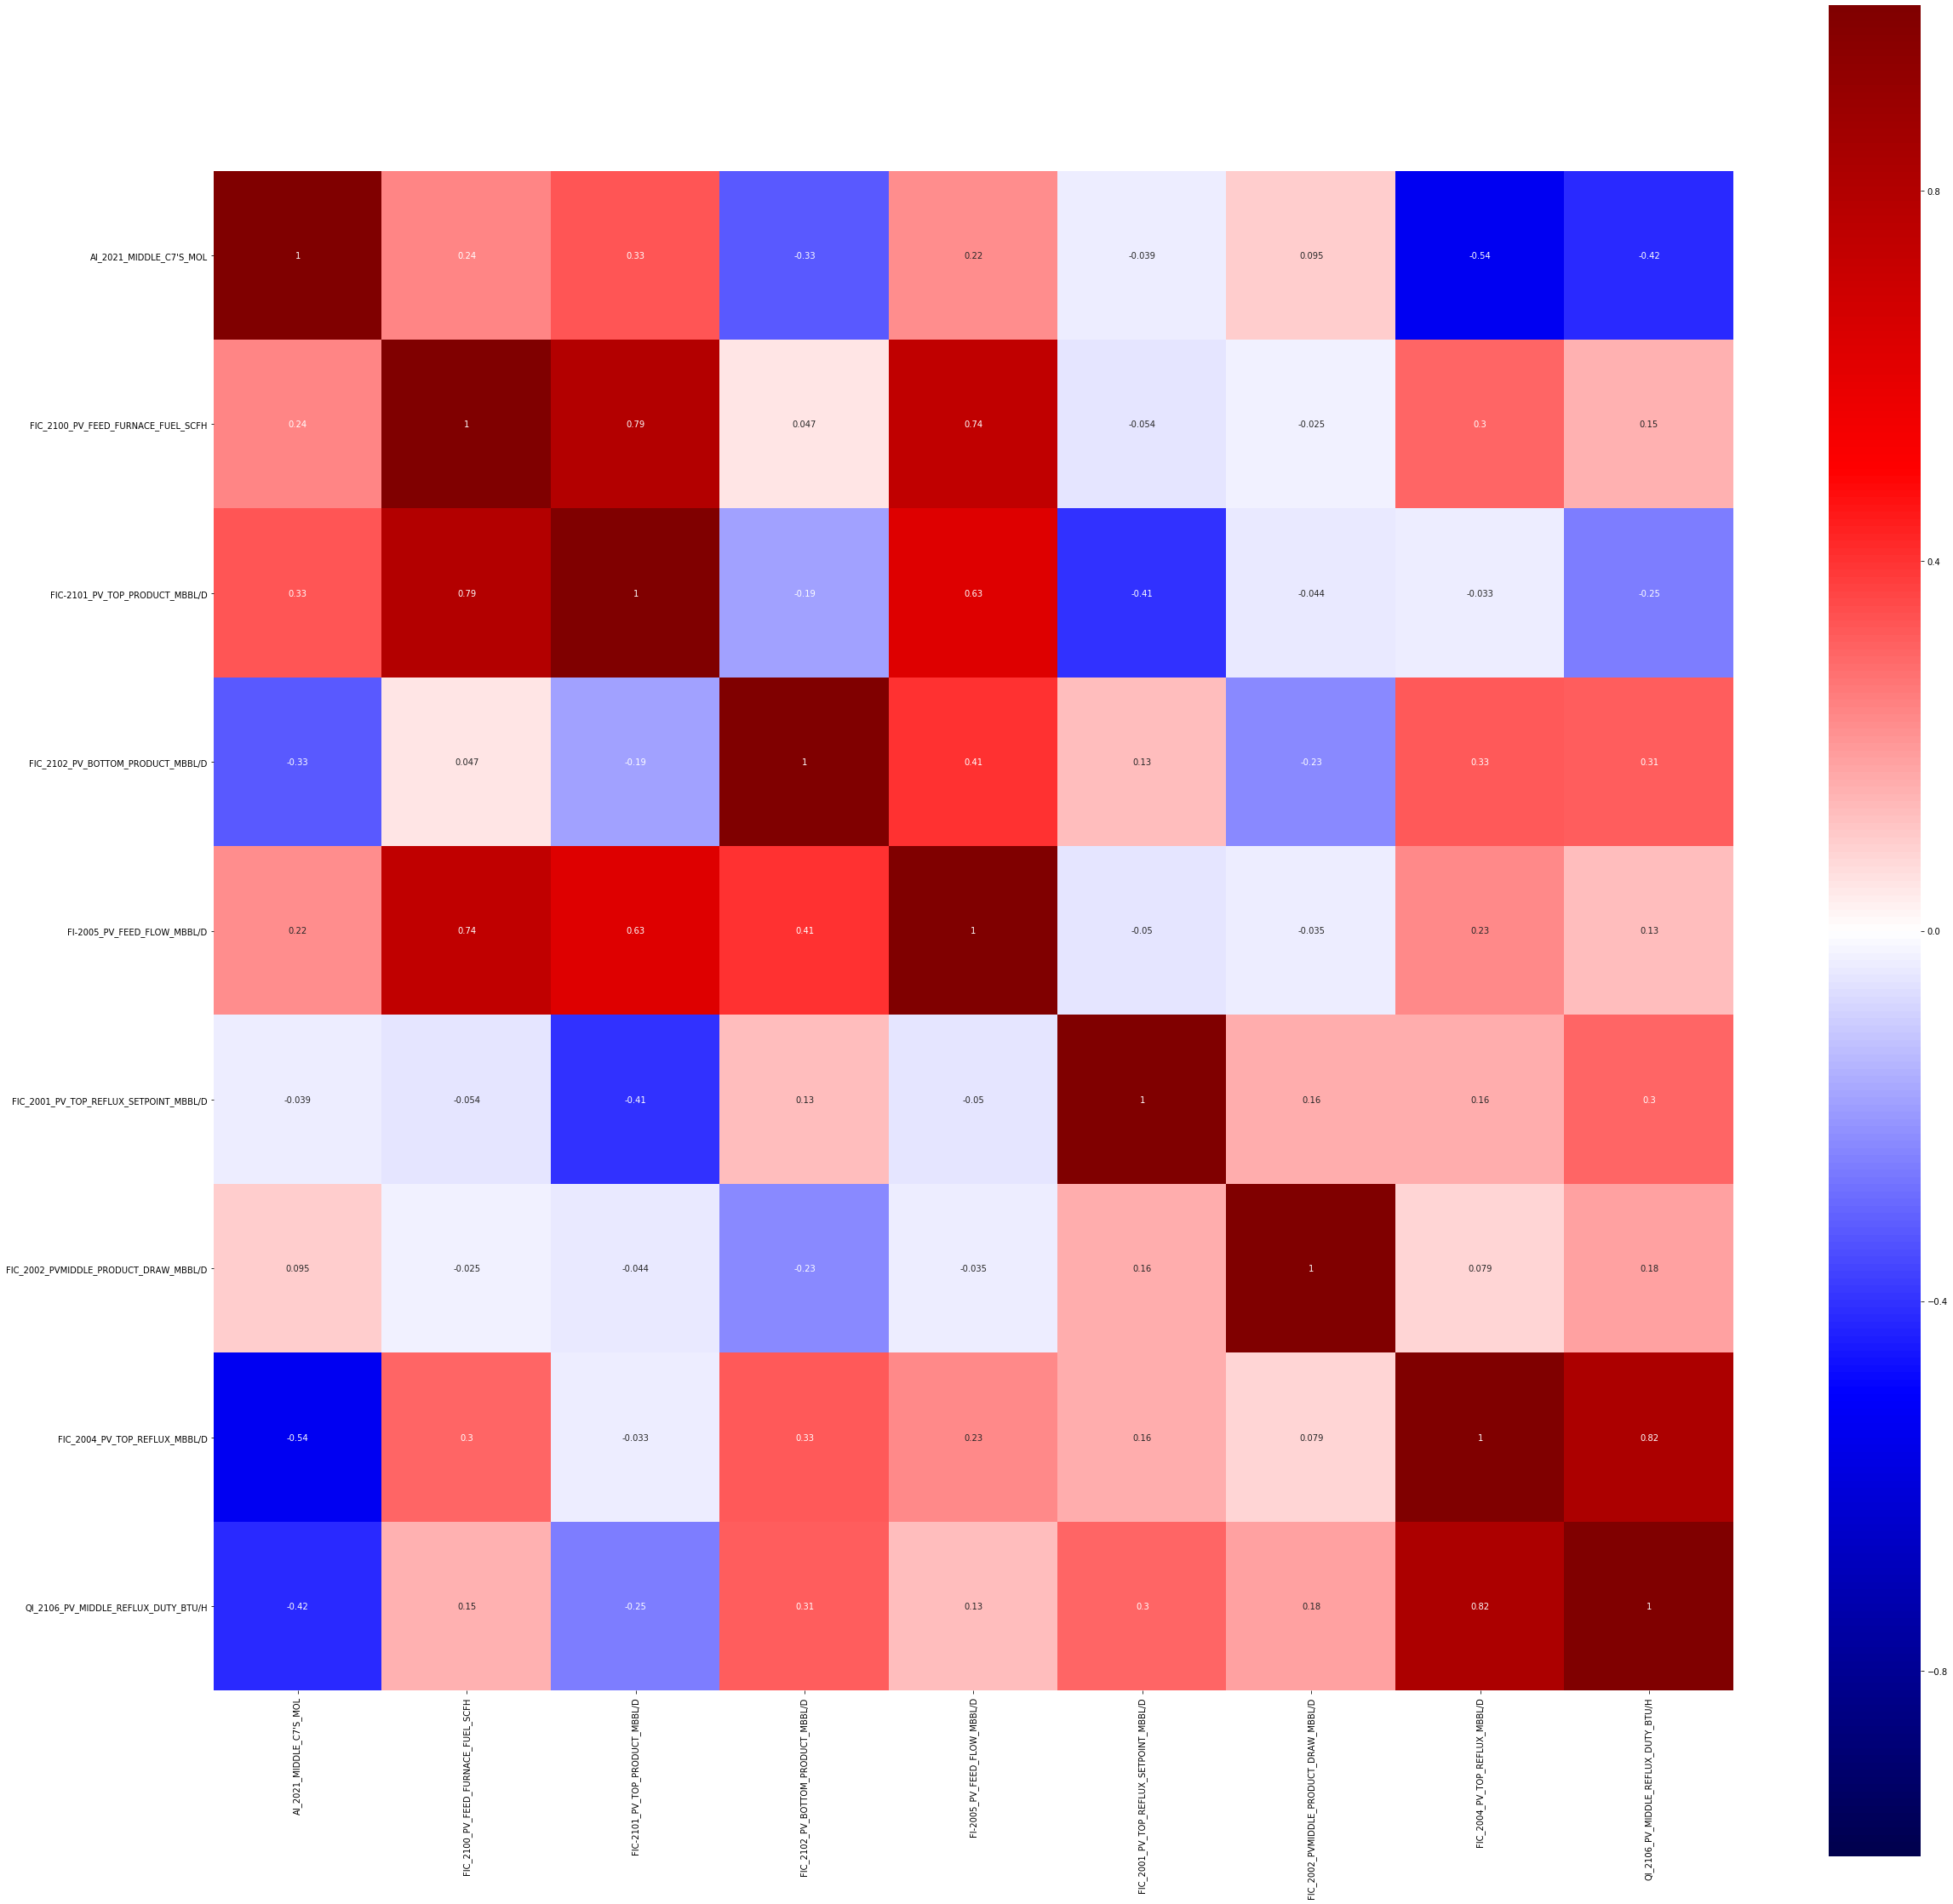

In [43]:
#find the correlation between features
plt.figure(figsize=(40,40))
fig3=sns.heatmap(df_AI_middle.corr(method='spearman'),vmin=-1,vmax=1,cmap= 'seismic',annot=True,square=True)
fig3.figure.savefig('heat map correlation AI_middle.png')
plt.show()

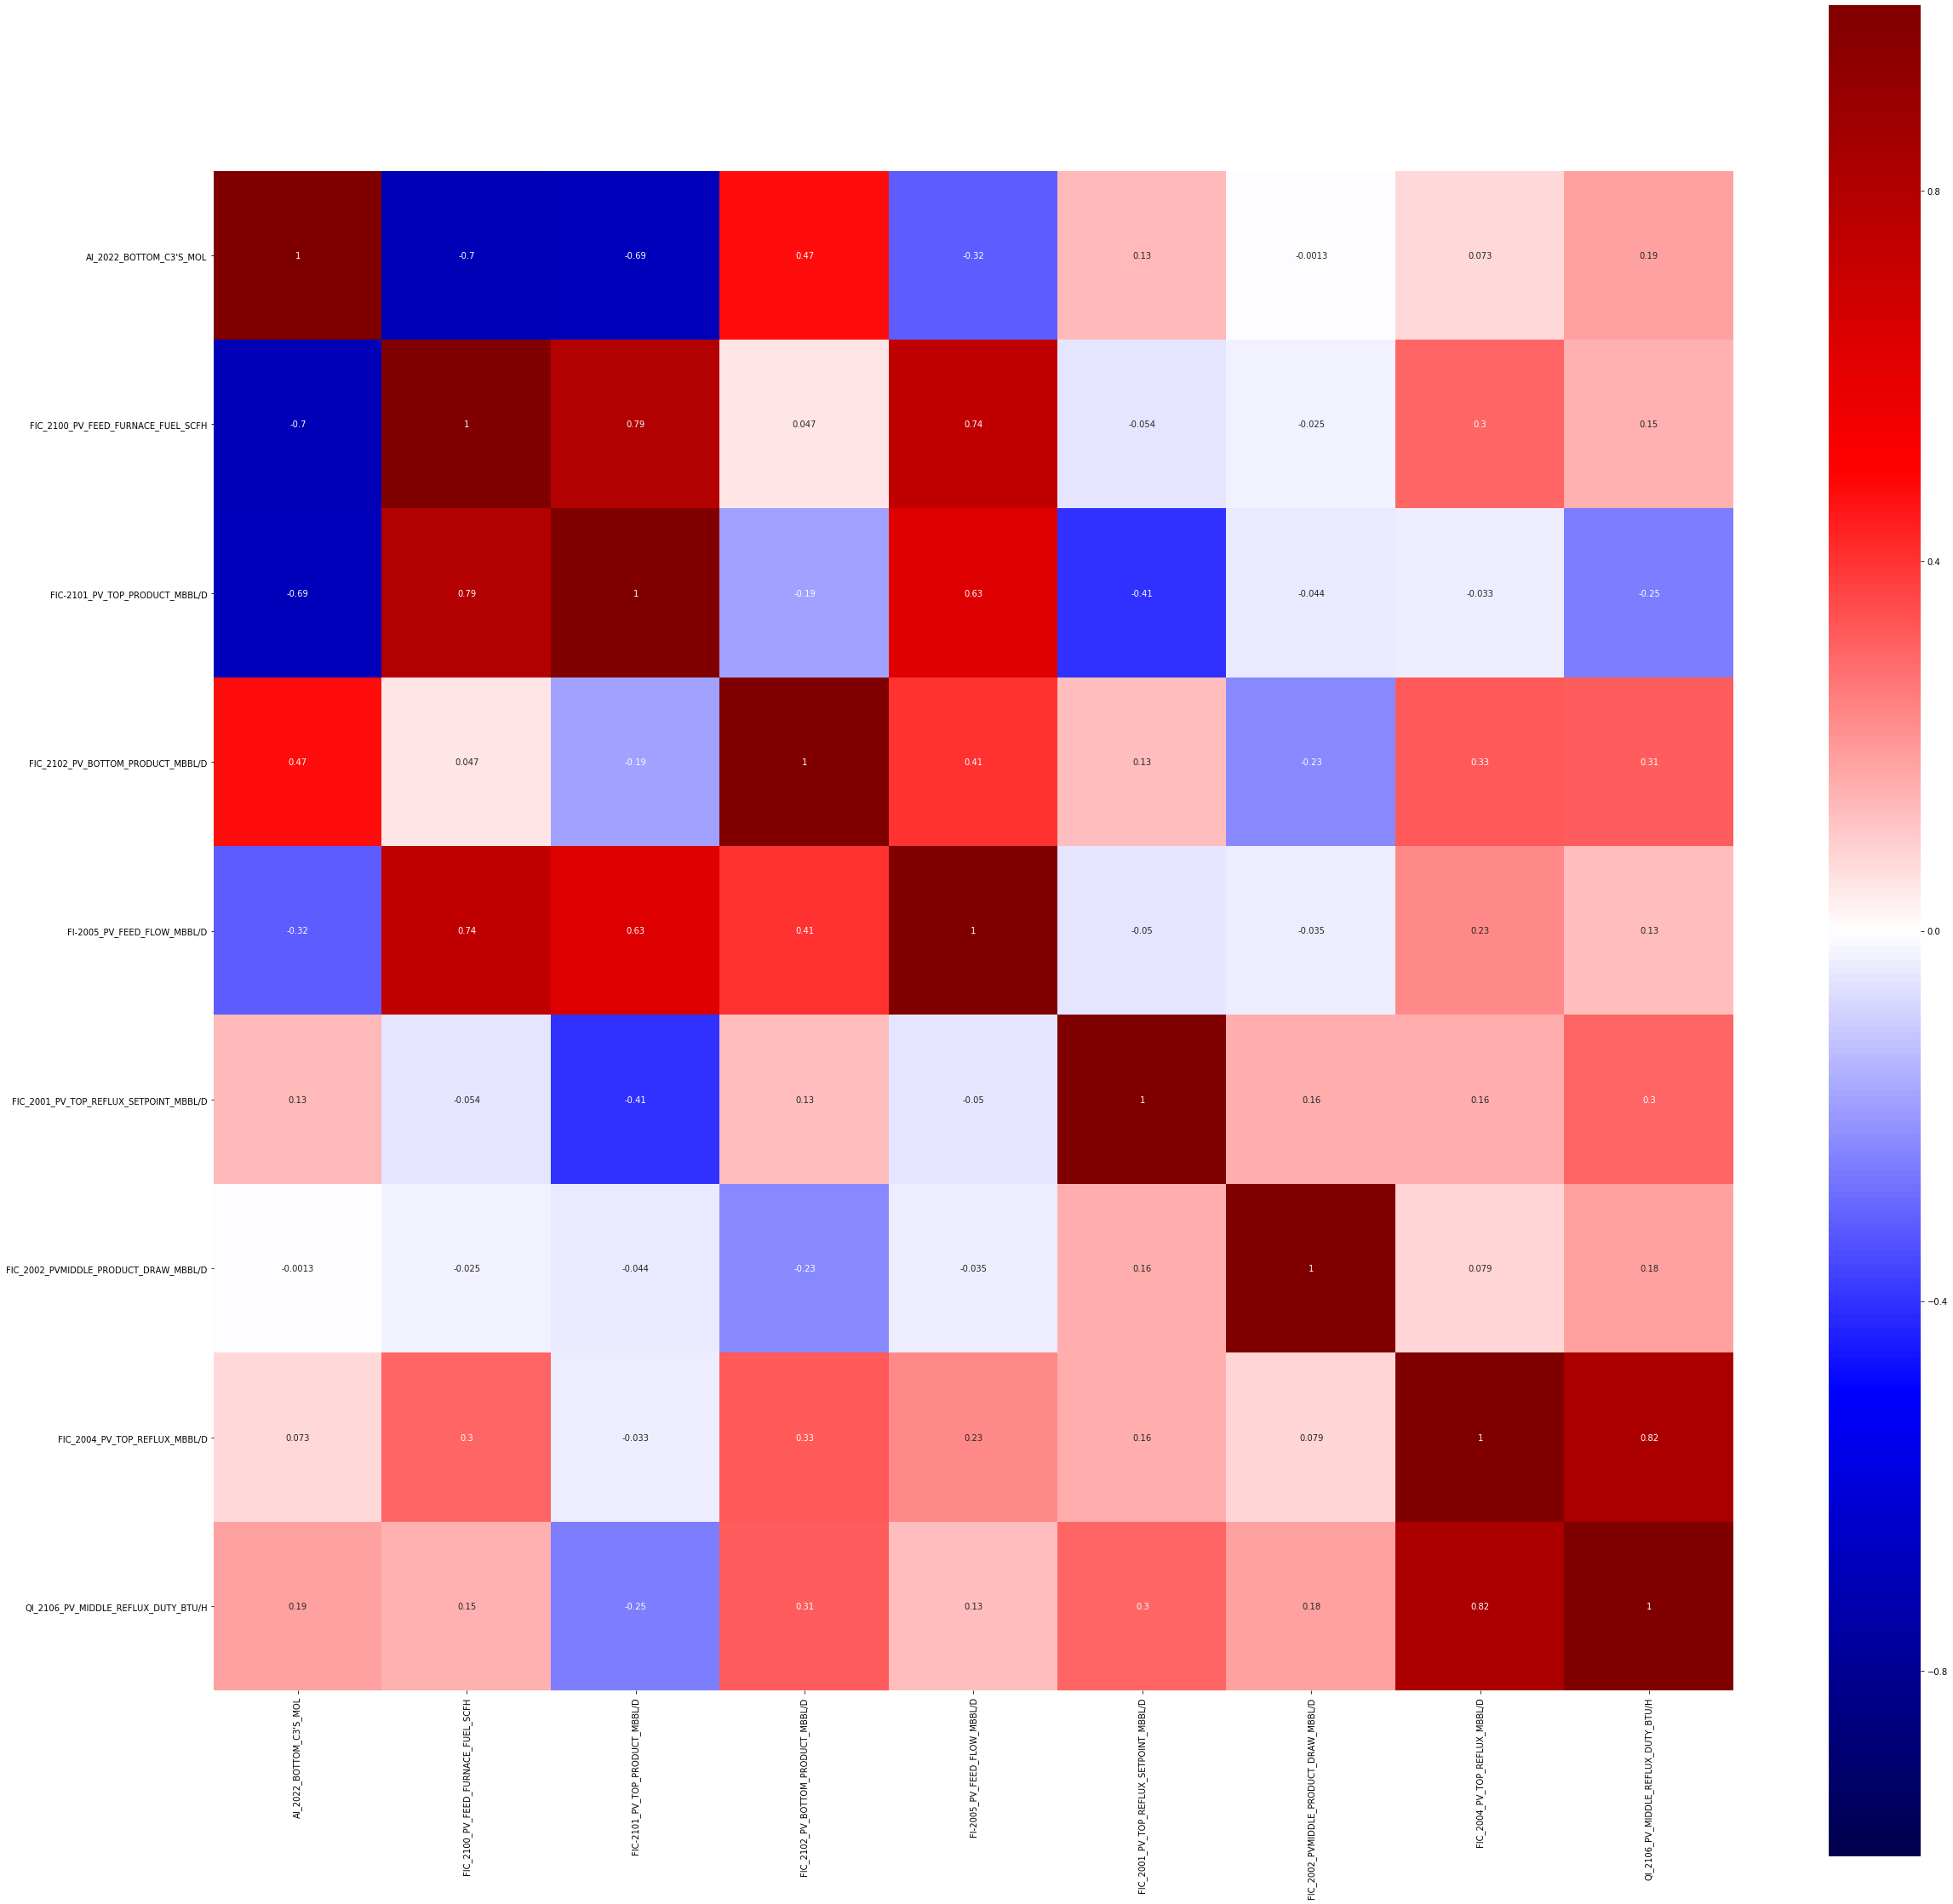

In [44]:
#find the correlation between features
plt.figure(figsize=(40,40))
fig4=sns.heatmap(df_AI_bottom.corr(method='spearman'),vmin=-1,vmax=1,cmap= 'seismic',annot=True,square=True)
fig4.figure.savefig('heat map correlation AI_bottom.png')
plt.show()

In [45]:
corr_AI_top=df_AI_top.corr()
corr_AI_top.to_csv("corr_AI_top.csv")

In [46]:
corr_AI_middle=df_AI_middle.corr()
corr_AI_middle.to_csv("corr_AI_middle.csv")

In [47]:
corr_AI_bottom=df_AI_bottom.corr()
corr_AI_bottom.to_csv("corr_AI_bottom.csv")

In [48]:
for i in response_variables:
    
    print(i)

FIC_2100_PV_FEED_FURNACE_FUEL_SCFH
FIC-2101_PV_TOP_PRODUCT_MBBL/D
FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D
FI-2005_PV_FEED_FLOW_MBBL/D
FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D
FIC_2002_PVMIDDLE_PRODUCT_DRAW_MBBL/D
FIC_2004_PV_TOP_REFLUX_MBBL/D
QI_2106_PV_MIDDLE_REFLUX_DUTY_BTU/H


### Using top and bottom analyzers to predict the values of the process variables (Top product draw flow)

#### Data Preprocessing and visualization ####

In [9]:
# for data dimensionality reduction as deduction of the number of features affecting the traget value.
df_top_product=df[["FIC-2101_PV_TOP_PRODUCT_MBBL/D","AI_2020_OVERHEAD_C5'S_MOL","AI_2022_BOTTOM_C3'S_MOL","FIC_2100_PV_FEED_FURNACE_FUEL_SCFH","FI-2005_PV_FEED_FLOW_MBBL/D"]]

In [10]:
df_top_product.rename(columns={"FIC-2101_PV_TOP_PRODUCT_MBBL/D":"Top_product","AI_2020_OVERHEAD_C5'S_MOL":"AI_top",
                               "AI_2022_BOTTOM_C3'S_MOL": "AI_bottom","FIC_2100_PV_FEED_FURNACE_FUEL_SCFH":"fuel","FI-2005_PV_FEED_FLOW_MBBL/D":"feed"}, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [11]:
df_top_product.head()

,Top_product,AI_top,AI_bottom,fuel,feed
0,2.10000,2.00000,4.00000,8.50000,5.02153
1,2.09686,2.00360,3.99831,8.50735,4.98768
2,2.09280,2.00870,3.97746,8.50977,4.93990
3,2.08587,2.00385,3.97262,8.50838,4.93333
4,2.08028,1.99852,3.98841,8.50365,4.96880


In [52]:
df_top_product.isnull().sum()

Top_product    0
AI_top         0
AI_bottom      0
dtype: int64

In [53]:
df_top_product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5729 entries, 0 to 5819
Data columns (total 3 columns):
Top_product    5729 non-null float64
AI_top         5729 non-null float64
AI_bottom      5729 non-null float64
dtypes: float64(3)
memory usage: 179.0 KB


In [54]:
discribe_data=df_top_product.describe()

In [55]:
discribe_data.to_csv("discribe_data.csv")

In [56]:
data_corr_top_product=df_top_product.corr(method='spearman')

In [57]:
data_corr_top_product.to_csv("data_corr_top_product.csv")

In [58]:
df_top_product.to_csv("df_top_product.csv")

##### DATA VISUALIZATION

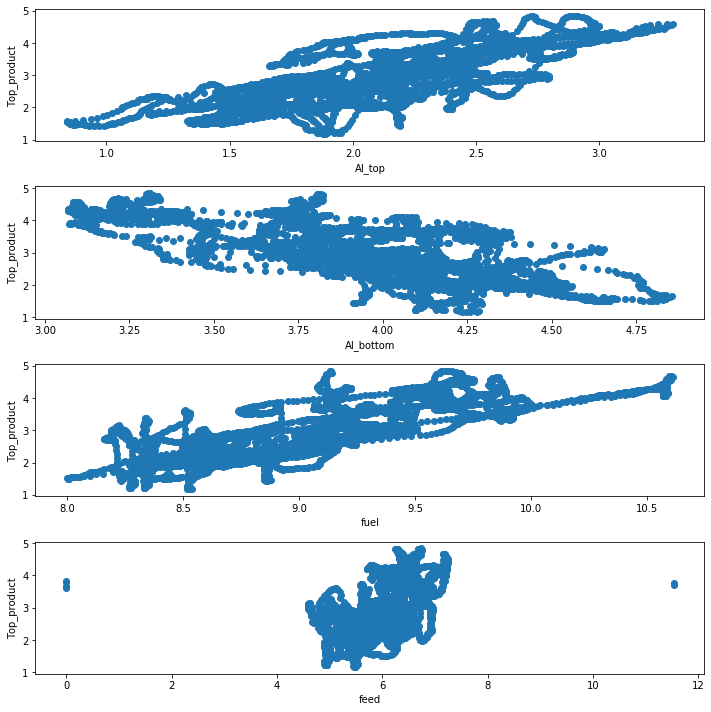

In [13]:
# Create subplots for each column pair
df_top_product_features=df_top_product[["AI_top","AI_bottom","fuel","feed"]]
fig, axs = plt.subplots(4,1, figsize=(10, 10))
axs = axs.flatten()
for i, col in enumerate(df_top_product_features.columns):
    axs[i].scatter(df_top_product_features[col], df_top_product["Top_product"])
    axs[i].set_xlabel(col)
    axs[i].set_ylabel("Top_product")

plt.tight_layout()
plt.show()

In [14]:
df_features=df_top_product[["AI_top","AI_bottom","fuel","feed"]]

In [15]:
df_target=df_top_product["Top_product"]

In [16]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [17]:

#Splitting data

X_train, X_test, y_train, y_test = train_test_split(df_features,df_target, test_size=0.33, shuffle =False)

#Splitted Data
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (3838, 4)
X_test shape is  (1891, 4)
y_train shape is  (3838,)
y_test shape is  (1891,)


In [18]:
LinearRegModel=LinearRegression(fit_intercept=True, normalize=True,copy_X=True,n_jobs=1)
LinearRegModel.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [19]:
print('Linear Regression Train Score is : ' , LinearRegModel.score(X_train, y_train))
print('Linear Regression Test Score is : ' , LinearRegModel.score(X_test, y_test))
print('Linear Regression Coef is : ' , LinearRegModel.coef_)
print('Linear Regression intercept is : ' , LinearRegModel.intercept_)
print('----------------------------------------------------')


Linear Regression Train Score is :  0.7348034018806653
Linear Regression Test Score is :  -0.41367833255829867
Linear Regression Coef is :  [ 0.80922923 -0.12411568  0.84494961 -0.26277343]
Linear Regression intercept is :  -4.494021931563639
----------------------------------------------------


In [20]:
#Calculating Prediction
y_pred = LinearRegModel.predict(X_test)
print('Predicted Value for Linear Regression is : ' , y_pred[:10])



Predicted Value for Linear Regression is :  [4.15006283 4.16003747 4.14318991 4.1399725  4.11859701 4.122657
 4.11016218 4.1023967  4.08613783 4.07984306]


In [21]:
y_test.index-=len(y_train)

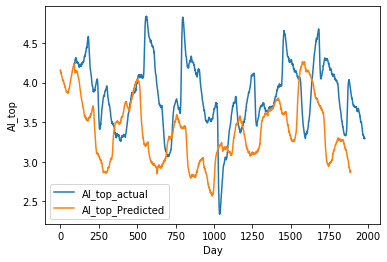

In [22]:
plt.plot(y_test, label='AI_top_actual')
plt.plot(y_pred, label='AI_top_Predicted')
plt.xlabel('Day')
plt.ylabel('AI_top')
plt.legend()
plt.show()

In [23]:
#Calculating Mean Absolute Error
MAEValue = mean_absolute_error(y_test, y_pred, multioutput='uniform_average') # it can be raw_values
print('Mean Absolute Error Value is : ', MAEValue)


Mean Absolute Error Value is :  0.44681503881573176


In [24]:
#Calculating Mean Squared Error
MSEValue = mean_squared_error(y_test, y_pred, multioutput='uniform_average') # it can be raw_values
print('Mean Squared Error Value is : ', MSEValue)


Mean Squared Error Value is :  0.25546520526194


In [25]:
#Calculating Median Squared Error
MdSEValue = median_absolute_error(y_test, y_pred)
print('Median Squared Error Value is : ', MdSEValue )
 


Median Squared Error Value is :  0.4215039790618125


In [26]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=6,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:2.05658	validation_1-rmse:3.33224
[100]	validation_0-rmse:0.77725	validation_1-rmse:1.69218
[200]	validation_0-rmse:0.31085	validation_1-rmse:1.09673
[300]	validation_0-rmse:0.14712	validation_1-rmse:0.88552
[400]	validation_0-rmse:0.09529	validation_1-rmse:0.81025
[500]	validation_0-rmse:0.07696	validation_1-rmse:0.78142
[600]	validation_0-rmse:0.06810	validation_1-rmse:0.76954
[700]	validation_0-rmse:0.06258	validation_1-rmse:0.76144
[800]	validation_0-rmse:0.05794	validation_1-rmse:0.75682
[900]	validation_0-rmse:0.05457	validation_1-rmse:0.75419
[999]	validation_0-rmse:0.05164	validation_1-rmse:0.75267


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, ...)

In [27]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [28]:
trained_predicted=reg.predict(X_train)


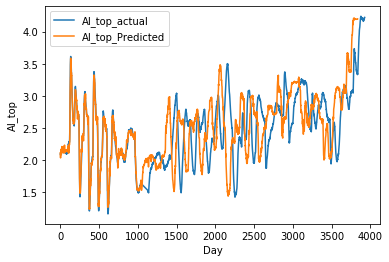

In [29]:
plt.plot(y_train, label='AI_top_actual')
plt.plot(trained_predicted, label='AI_top_Predicted')
plt.xlabel('Day')
plt.ylabel('AI_top')
plt.legend()
plt.show()

In [30]:
tested_predicted=reg.predict(X_test)


In [108]:
y_test.index-=len(y_train)

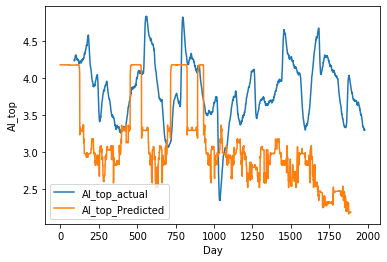

In [109]:
plt.plot(y_test, label='AI_top_actual')
plt.plot(tested_predicted, label='AI_top_Predicted')
plt.xlabel('Day')
plt.ylabel('AI_top')
plt.legend()
plt.show()

In [113]:
!pip install torch

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import sklearn
from scipy import stats
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import median_absolute_error
from datetime import date
from sklearn.preprocessing import MinMaxScaler


In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3838, 4), (1891, 4), (3838,), (1891,))

In [33]:
X_train=X_train.values
y_train=y_train.values
y_test=y_test.values
X_test=X_test.values

In [34]:
window_size=6
X_train = X_train.reshape((-1, 4,1))
X_test = X_test.reshape((-1, 4,1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3838, 4, 1), (1891, 4, 1), (3838, 1), (1891, 1))

In [35]:
X_train [0]

array([[2.     ],
       [4.     ],
       [8.5    ],
       [5.02153]])

In [36]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3838, 4, 1]),
 torch.Size([1891, 4, 1]),
 torch.Size([3838, 1]),
 torch.Size([1891, 1]))

In [37]:
X_train [0]

tensor([[2.0000],
        [4.0000],
        [8.5000],
        [5.0215]])

In [38]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [39]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [40]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [41]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 4, 1]) torch.Size([16, 1])


In [42]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4,1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [43]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0

In [44]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [45]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 8.695
Batch 200, Loss: 6.564
Val Loss: 10.350
***************************************************

Epoch: 2
Batch 100, Loss: 2.670
Batch 200, Loss: 1.262
Val Loss: 3.783
***************************************************

Epoch: 3
Batch 100, Loss: 0.468
Batch 200, Loss: 0.329
Val Loss: 2.148
***************************************************

Epoch: 4
Batch 100, Loss: 0.296
Batch 200, Loss: 0.295
Val Loss: 1.934
***************************************************

Epoch: 5
Batch 100, Loss: 0.283
Batch 200, Loss: 0.286
Val Loss: 1.907
***************************************************

Epoch: 6
Batch 100, Loss: 0.273
Batch 200, Loss: 0.295
Val Loss: 1.887
***************************************************

Epoch: 7
Batch 100, Loss: 0.284
Batch 200, Loss: 0.288
Val Loss: 1.889
***************************************************

Epoch: 8
Batch 100, Loss: 0.289
Batch 200, Loss: 0.296
Val Loss: 1.882
***************************************************

Epoch: 

In [46]:
mode_eval=model.eval()

In [47]:
#Calculating Prediction
with torch.no_grad():
    output_tensor = mode_eval(X_test)
y_pred=output_tensor.numpy()
print('Predicted Value for Linear Regression is : ' , y_pred[:10])



Predicted Value for Linear Regression is :  [[4.2166553]
 [4.2092285]
 [4.201912 ]
 [4.1991363]
 [4.1692467]
 [4.1629515]
 [4.1451817]
 [4.1310463]
 [4.1227837]
 [4.121694 ]]


In [48]:
#Calculating Mean Absolute Error
MAEValue = mean_absolute_error(y_test, y_pred, multioutput='uniform_average') # it can be raw_values
print('Mean Absolute Error Value is : ', MAEValue)


Mean Absolute Error Value is :  0.5152606


In [49]:
#Calculating Mean Squared Error
MSEValue = mean_squared_error(y_test, y_pred, multioutput='uniform_average') # it can be raw_values
print('Mean Squared Error Value is : ', MSEValue)


Mean Squared Error Value is :  0.34434083


In [50]:
#Calculating Median Squared Error
MdSEValue = median_absolute_error(y_test, y_pred)
print('Median Squared Error Value is : ', MdSEValue )
 


Median Squared Error Value is :  0.5684948


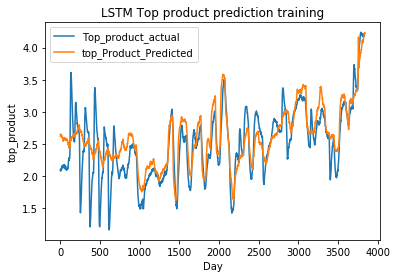

In [55]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Top_product_actual')
plt.plot(predicted, label='top_Product_Predicted')
plt.xlabel('Day')
plt.ylabel('top_product')
plt.legend()
plt.title("LSTM Top product prediction training")
plt.savefig("LSTM Top product prediction training")
plt.show()


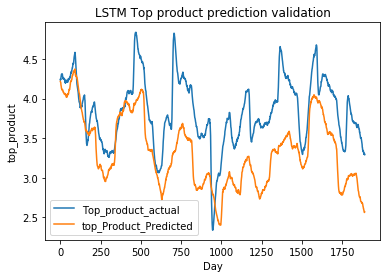

In [56]:
with torch.no_grad():
    predicted = model(X_test.to(device)).to('cpu').numpy()

plt.plot(y_test, label='Top_product_actual')
plt.plot(predicted, label='top_Product_Predicted')
plt.xlabel('Day')
plt.ylabel('top_product')
plt.legend()
plt.title("LSTM Top product prediction validation")
plt.savefig("LSTM Top product prediction validation")
plt.show()


## TapTransformers

In [108]:
df_features=df_top_product[["AI_top","AI_bottom","fuel","feed"]]

In [109]:
df_target=df_top_product["Top_product"]

In [191]:

#Splitting data

X_train, X_test, y_train, y_test = train_test_split(df_features,df_target, test_size=0.33, shuffle =False)

#Splitted Data
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (3838, 4)
X_test shape is  (1891, 4)
y_train shape is  (3838,)
y_test shape is  (1891,)


In [192]:
X_train=X_train.values
y_train=y_train.values
y_test=y_test.values
X_test=X_test.values

In [193]:

X_train = X_train.reshape((-1,1 ,4))
X_test = X_test.reshape((-1, 1,4))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3838, 1, 4), (1891, 1, 4), (3838, 1), (1891, 1))

In [194]:
X_train [0]

array([[2.     , 4.     , 8.5    , 5.02153]])

In [195]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3838, 1, 4]),
 torch.Size([1891, 1, 4]),
 torch.Size([3838, 1]),
 torch.Size([1891, 1]))

In [198]:
X_train [0]

tensor([[2.0000, 4.0000, 8.5000, 5.0215]])

In [199]:
from torch.utils.data import Dataset

class TapReg(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TapReg(X_train, y_train)
test_dataset = TapReg(X_test, y_test)

In [200]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [201]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [202]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 1, 4]) torch.Size([16, 1])


In [203]:
# Define the TabTransformer model
class TabTransformer(nn.Module):
    def __init__(self, input_size, output_size, num_layers, d_model, num_heads, dim_feedforward, dropout):
        super(TabTransformer, self).__init__()

        self.embedding = nn.Linear(input_size, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=num_heads,
                dim_feedforward=dim_feedforward,
                dropout=dropout
            ),
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1,0, 2)
        x = self.transformer(x)
        x = x.permute(1, 0,2)
        x = self.fc(x[:, -1, :])
        return x

In [204]:

# Set the hyperparameters
input_size = 4
output_size = 1
num_layers = 3
d_model = 32
num_heads = 4
dim_feedforward = 64
dropout = 0.1
lr = 0.001
batch_size = 64
num_epochs = 100
seq_len = 12

In [205]:
# Define the model, loss function, and optimizer
model = TabTransformer(input_size, output_size, num_layers, d_model, num_heads, dim_feedforward, dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [206]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0

In [207]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [208]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [209]:

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.563
Batch 200, Loss: 0.245
Val Loss: 0.922
***************************************************

Epoch: 2
Batch 100, Loss: 0.137
Batch 200, Loss: 0.115
Val Loss: 0.469
***************************************************

Epoch: 3
Batch 100, Loss: 0.120
Batch 200, Loss: 0.105
Val Loss: 0.580
***************************************************

Epoch: 4
Batch 100, Loss: 0.109
Batch 200, Loss: 0.100
Val Loss: 0.477
***************************************************

Epoch: 5
Batch 100, Loss: 0.098
Batch 200, Loss: 0.100
Val Loss: 0.523
***************************************************

Epoch: 6
Batch 100, Loss: 0.104
Batch 200, Loss: 0.093
Val Loss: 0.521
***************************************************

Epoch: 7
Batch 100, Loss: 0.088
Batch 200, Loss: 0.101
Val Loss: 0.398
***************************************************

Epoch: 8
Batch 100, Loss: 0.096
Batch 200, Loss: 0.107
Val Loss: 0.354
***************************************************

Epoch: 9

AttributeError: 'TabTransformer' object has no attribute 'avg_loss_across_batches'

In [210]:
with torch.no_grad():
    predicted_train = model(X_train.to(device)).to('cpu').numpy()

In [211]:
with torch.no_grad():
    predicted_test = model(X_test.to(device)).to('cpu').numpy()


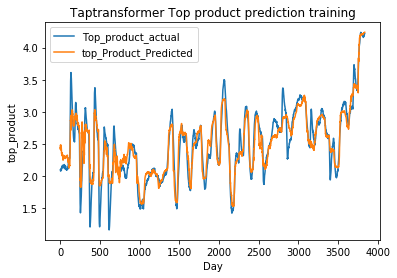

In [212]:
plt.plot(y_train, label='Top_product_actual')
plt.plot(predicted_train, label='top_Product_Predicted')
plt.xlabel('Day')
plt.ylabel('top_product')
plt.legend()
plt.title("Taptransformer Top product prediction training")
plt.savefig("Tabtransformer Top product prediction training")
plt.show()


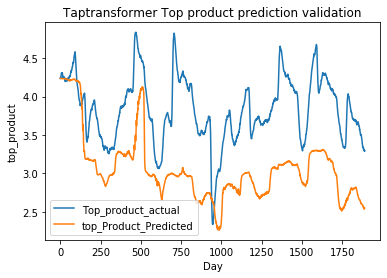

In [213]:
plt.plot(y_test, label='Top_product_actual')
plt.plot(predicted_test, label='top_Product_Predicted')
plt.xlabel('Day')
plt.ylabel('top_product')
plt.legend()
plt.title("Taptransformer Top product prediction validation")
plt.savefig("taptransformer Top product prediction validation")
plt.show()

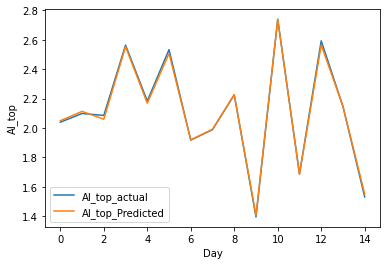

In [37]:
plt.plot(y_train, label='AI_top_actual')
plt.plot(predicted_train, label='AI_top_Predicted')
plt.xlabel('Day')
plt.ylabel('AI_top')
plt.legend()
plt.show()

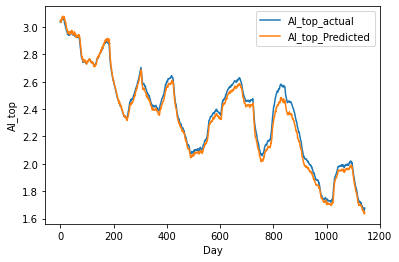

In [38]:
plt.plot(y_test, label='AI_top_actual')
plt.plot(predicted_test, label='AI_top_Predicted')
plt.xlabel('Day')
plt.ylabel('AI_top')
plt.legend()
plt.show()

In [233]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_boston


In [234]:

# Load the Boston Housing dataset
boston = load_boston()

In [235]:

# Define the input features and target variable
X = boston.data
y = boston.target

In [236]:
# Define the XGBoost model
model = xgb.XGBRegressor()


In [237]:


# Define the hyperparameters to tune
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    'reg_lambda': [0.1, 1, 10]
}

In [238]:




# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X, y)

# Print the best hyperparameters and score
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_lambda': 1}
Best score: 0.6878562356253033


In [239]:
df_features=df_top_product[["AI_top","AI_bottom"]]

In [240]:
df_target=df_top_product["Top_product"]

In [216]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3838, 2, 1]),
 torch.Size([1891, 2, 1]),
 torch.Size([3838, 1]),
 torch.Size([1891, 1]))

In [241]:
X_train [0]

tensor([[2.],
        [4.]])

In [245]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [246]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [247]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [248]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 2, 1]) torch.Size([16, 1])


In [255]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

#model = LSTM(1, 2,1)
model.to(device)
model

LSTM(
  (lstm): LSTM(2, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [256]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0

In [257]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [264]:
# Define the LSTM model hyperparameters
input_size = 2
hidden_size = 16
output_size = 1

# Define the hyperparameters to tune
param_grid = {
    'hidden_size': [16, 32, 64],
    'learning_rate': [0.1, 0.01, 0.001],
    'num_layers': [1, 2, 3],
    'batch_size': [16, 32, 64],
    'num_epochs': [50, 100, 200]
}

# Define the loss function and optimizer
criterion = nn.MSELoss()

# Define the LSTM model
model = LSTM(input_size, hidden_size, output_size)

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(train_loader)

# Print the best hyperparameters and score
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

TypeError: estimator should be an estimator implementing 'fit' method, LSTM(
  (lstm): LSTM(2, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
) was passed

In [226]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.208
Batch 200, Loss: 0.204
Val Loss: 1.388
***************************************************

Epoch: 2
Batch 100, Loss: 0.194
Batch 200, Loss: 0.193
Val Loss: 1.267
***************************************************

Epoch: 3
Batch 100, Loss: 0.187
Batch 200, Loss: 0.179
Val Loss: 1.144
***************************************************

Epoch: 4
Batch 100, Loss: 0.174
Batch 200, Loss: 0.164
Val Loss: 1.103
***************************************************

Epoch: 5
Batch 100, Loss: 0.159
Batch 200, Loss: 0.176
Val Loss: 1.015
***************************************************

Epoch: 6
Batch 100, Loss: 0.164
Batch 200, Loss: 0.159
Val Loss: 1.081
***************************************************

Epoch: 7
Batch 100, Loss: 0.159
Batch 200, Loss: 0.159
Val Loss: 0.969
***************************************************

Epoch: 8
Batch 100, Loss: 0.153
Batch 200, Loss: 0.154
Val Loss: 0.980
***************************************************

Epoch: 9

In [227]:
mode_eval=model.eval()

In [228]:
#Calculating Prediction
with torch.no_grad():
    output_tensor = mode_eval(X_test)
y_pred=output_tensor.numpy()
print('Predicted Value for Linear Regression is : ' , y_pred[:10])



Predicted Value for Linear Regression is :  [[4.11422  ]
 [4.1023507]
 [4.0993447]
 [4.0977902]
 [4.0675154]
 [4.0586805]
 [4.0408225]
 [4.0265837]
 [4.022114 ]
 [4.0232143]]


In [229]:
#Calculating Mean Absolute Error
MAEValue = mean_absolute_error(y_test, y_pred, multioutput='uniform_average') # it can be raw_values
print('Mean Absolute Error Value is : ', MAEValue)


Mean Absolute Error Value is :  0.74784094


In [230]:
#Calculating Mean Squared Error
MSEValue = mean_squared_error(y_test, y_pred, multioutput='uniform_average') # it can be raw_values
print('Mean Squared Error Value is : ', MSEValue)


Mean Squared Error Value is :  0.6939029


In [231]:
#Calculating Median Squared Error
MdSEValue = median_absolute_error(y_test, y_pred)
print('Median Squared Error Value is : ', MdSEValue )
 


Median Squared Error Value is :  0.8453419


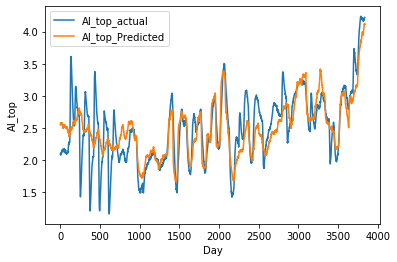

In [232]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='AI_top_actual')
plt.plot(predicted, label='AI_top_Predicted')
plt.xlabel('Day')
plt.ylabel('AI_top')
plt.legend()
plt.show()


In [211]:

#Splitting data

X_train, X_test, y_train, y_test = train_test_split(df_features,df_target, test_size=0.33, shuffle =False)

#Splitted Data
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (3838, 2)
X_test shape is  (1891, 2)
y_train shape is  (3838,)
y_test shape is  (1891,)


In [269]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import GridSearchCV

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        
        # Pass input through the LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        
        # Pass the last output of the LSTM layer through the fully connected layer
        out = self.fc(out[:, -1, :])
        return out


# Convert the input data to a PyTorch tensor
input_tensor = X_train
target_tensor = y_train
# Define the LSTM model hyperparameters
input_size = 2
#hidden_size = 16
output_size = 1

# Define the hyperparameters to tune
param_grid = {
    'hidden_size': [16, 32, 64],
    'learning_rate': [0.1, 0.01, 0.001],
    'num_layers': [1, 2, 3],
    'batch_size': [16, 32, 64],
    'num_epochs': [50, 100, 200]
}

# Define the loss function and optimizer
criterion = nn.MSELoss()

# Define the LSTM model
model = LSTM(input_size, hidden_size, output_size)

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(input_tensor,target_tensor)

# Print the best hyperparameters and score
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)


TypeError: estimator should be an estimator implementing 'fit' method, LSTM(
  (lstm): LSTM(2, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
) was passed

In [270]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3838, 2, 1]),
 torch.Size([1891, 2, 1]),
 torch.Size([3838, 1]),
 torch.Size([1891, 1]))

In [213]:
X_train=X_train.values
y_train=y_train.values
y_test=y_test.values
X_test=X_test.values

In [214]:
X_train = X_train.reshape((-1, 2,1))
X_test = X_test.reshape((-1, 2,1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3838, 2, 1), (1891, 2, 1), (3838, 1), (1891, 1))

In [271]:
X_train [0]

tensor([[2.],
        [4.]])

In [216]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3838, 2, 1]),
 torch.Size([1891, 2, 1]),
 torch.Size([3838, 1]),
 torch.Size([1891, 1]))

In [280]:
X_train = X_train.numpy()
y_train =y_train.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3838, 2, 1), (1891, 2, 1), (3838, 1), (1891, 1))

In [281]:
X_train [0]

array([[2.],
       [4.]], dtype=float32)

In [218]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [219]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [220]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [221]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 2, 1]) torch.Size([16, 1])


In [282]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        
        # Pass input through the LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        
        # Pass the last output of the LSTM layer through the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Prepare the data
X = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]])
y = np.array([3, 5, 7,Here's an example code snippet for building an LSTM regression model with two inputs and one output, and performing hyperparameter tuning using scikit-learn's GridSearchCV:

```python

In [ ]:
# Split the data into training and test sets
train_ratio = 0.8
train_size = int(train_ratio * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


In [283]:
# Define the LSTM model hyperparameters
input_size = 2
hidden_size = 16
output_size = 1

In [284]:
# Define the hyperparameters to tune using grid search
param_grid = {
    'hidden_size': [16, 32, 64],
    'learning_rate': [0.1, 0.01, 0.001],
    'num_layers': [1, 2, 3],
    'batch_size': [16, 32, 64],
    'num_epochs': [50, 100, 200]
}

In [285]:
# Define the loss function and optimizer
criterion = nn.MSELoss()


In [286]:
# Define the LSTM model
model = LSTM(input_size, hidden_size, output_size)

In [287]:

# Convert the training data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()


In [279]:
# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

TypeError: estimator should be an estimator implementing 'fit' method, LSTM(
  (lstm): LSTM(2, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
) was passed

In [ ]:
# Print the best hyperparameters and score
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)